# Market Predictions using Leading Indicators

### Data Prep

In [3]:
# Importing libraries
from fredapi import Fred
import yfinance as yf

# API Key
FRED_API_KEY = "4614f29fed47a81be5ff4b180112ee8c"

# API Key call
fred = Fred(api_key=FRED_API_KEY)

# Pulling data

# New Vehicle Sales
car_sales = fred.get_series('TOTALSA')

# Gold
gold_price = fred.get_series('IR14270')

# Lumber
ppi_lumber = fred.get_series('WPU0811')

# Major Market Indexes from Yahoo Finance
sp500 = yf.download('^GSPC', start='2000-01-01')
nasdaq = yf.download('^IXIC', start='2000-01-01')
dow = yf.download('^DJI', start='2000-01-01')

/var/folders/xh/6p519lr15m14xl0whx7dxdx80000gn/T/ipykernel_1366/958621483.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start='2000-01-01')
[*********************100%***********************]  1 of 1 completed
/var/folders/xh/6p519lr15m14xl0whx7dxdx80000gn/T/ipykernel_1366/958621483.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nasdaq = yf.download('^IXIC', start='2000-01-01')
[*********************100%***********************]  1 of 1 completed
/var/folders/xh/6p519lr15m14xl0whx7dxdx80000gn/T/ipykernel_1366/958621483.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dow = yf.download('^DJI', start='2000-01-01')
[*********************100%***********************]  1 of 1 completed


In [4]:
# Import library
import pandas as pd

# Creating pandas data frames
df_car_sales = car_sales.reset_index()
df_car_sales.columns = ['DATE', 'Car_Sales_SAAR']
df_car_sales['DATE'] = pd.to_datetime(df_car_sales['DATE'])
df_car_sales = df_car_sales.set_index('DATE')

df_gold = gold_price.reset_index()
df_gold.columns = ['DATE', 'Gold_Price_USD']
df_gold['DATE'] = pd.to_datetime(df_gold['DATE'])
df_gold = df_gold.set_index('DATE')

df_lumber = ppi_lumber.reset_index()
df_lumber.columns = ['DATE', 'Lumber_Price_Index']
df_lumber['DATE'] = pd.to_datetime(df_lumber['DATE'])
df_lumber = df_lumber.set_index('DATE')

df_sp500 = sp500[['Close']].reset_index()
df_sp500.columns = ['DATE', 'SP500_Close']
df_sp500['DATE'] = pd.to_datetime(df_sp500['DATE'])
df_sp500 = df_sp500.set_index('DATE')

df_nasdaq = nasdaq[['Close']].reset_index()
df_nasdaq.columns = ['DATE', 'NASDAQ_Close']
df_nasdaq['DATE'] = pd.to_datetime(df_nasdaq['DATE'])
df_nasdaq = df_nasdaq.set_index('DATE')

df_dow = dow[['Close']].reset_index()
df_dow.columns = ['DATE', 'DOW_Close']
df_dow['DATE'] = pd.to_datetime(df_dow['DATE'])
df_dow = df_dow.set_index('DATE')

In [5]:
# Merging data frames
df_merged = (
    df_car_sales
    .join(df_gold, how='outer')
    .join(df_lumber, how='outer')
    .join(df_sp500, how='outer')
    .join(df_nasdaq, how='outer')
    .join(df_dow, how='outer')
)

# Filtering by date
df_merged = df_merged[df_merged.index >= '2000-01-01']
df_merged = df_merged[df_merged.index <= '2020-01-01']

In [6]:
# Iterpolation
df_interpolated = df_merged.interpolate(method='linear')

# Smothing by linear means
df_smoothed = df_interpolated.rolling(window=30, min_periods=1).mean()

In [7]:
df_smoothed.head()

,Car_Sales_SAAR,Gold_Price_USD,Lumber_Price_Index,SP500_Close,NASDAQ_Close,DOW_Close
DATE,,,,,,
2000-01-01,18.635000,10.5,194.800000,NaN,NaN,NaN
2000-01-03,18.653238,10.5,194.797619,1455.219971,4131.149902,11357.509766
2000-01-04,18.671476,10.5,194.795238,1427.320007,4016.419922,11177.719727
2000-01-05,18.689714,10.5,194.792857,1418.916667,3970.126628,11159.363281
2000-01-06,18.707952,10.5,194.790476,1415.049988,3909.377441,11182.837402


## Gold to Lumber Relationship Analysis

/var/folders/xh/6p519lr15m14xl0whx7dxdx80000gn/T/ipykernel_1366/340659091.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_merged[['Gold_Price_USD', 'Lumber_Price_Index']].resample('M').mean()


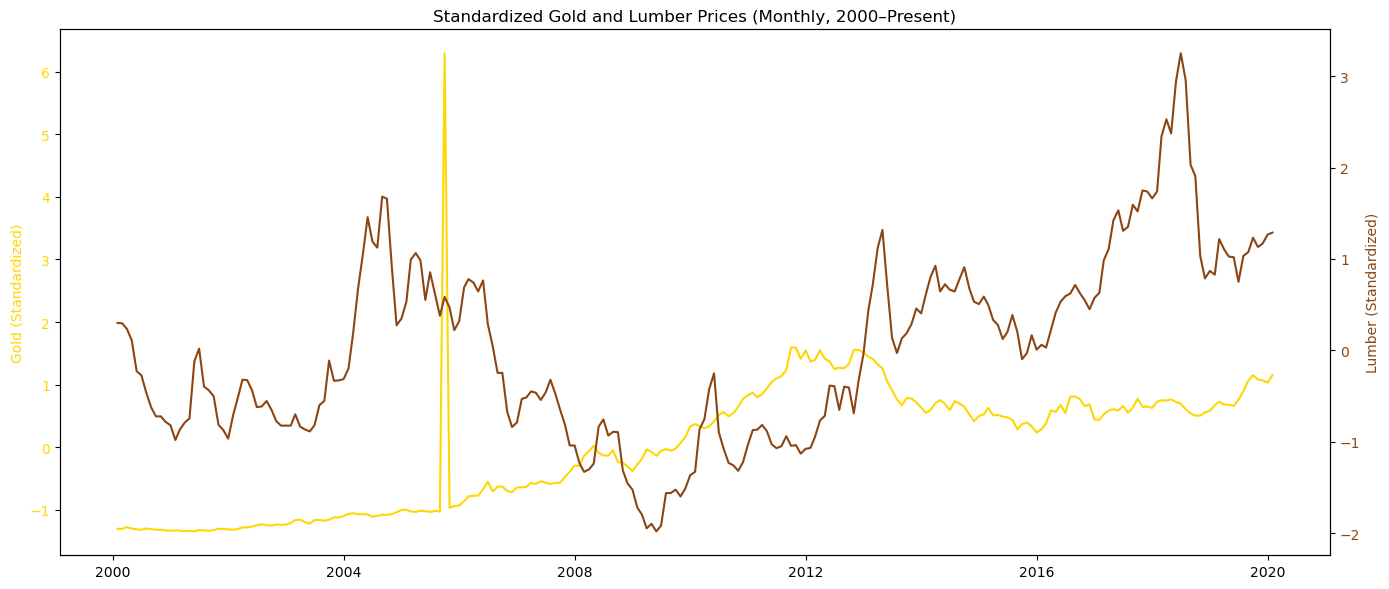

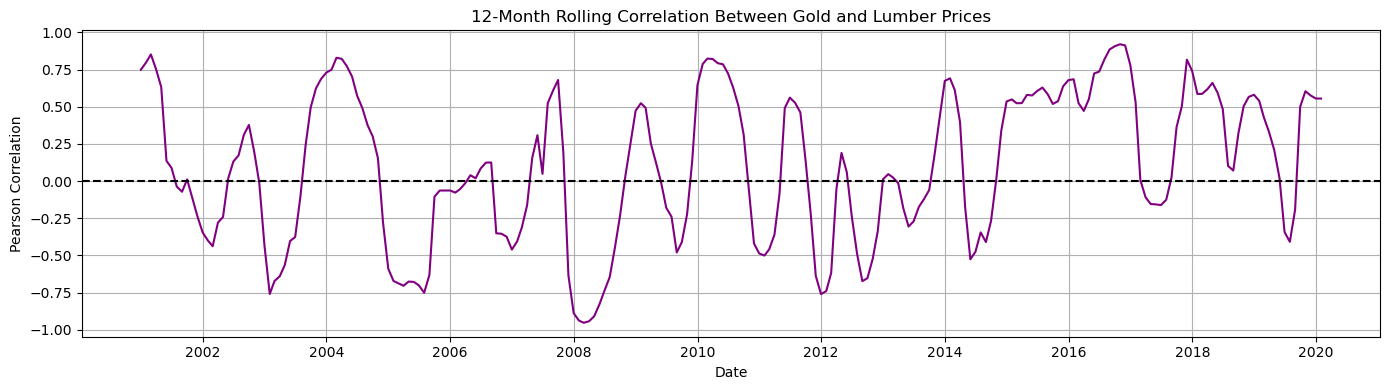

Full-period correlation: 0.20747945716319505
Pre-2008 correlation: -0.02281801852470794
Post-2008 correlation: 0.12764198001963212


In [9]:
# Importing libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Resampling for gold and lumber monthly means
monthly = df_merged[['Gold_Price_USD', 'Lumber_Price_Index']].resample('M').mean()

# Standardize data
scaler = StandardScaler()
monthly_scaled = pd.DataFrame(
    scaler.fit_transform(monthly),
    columns=['Gold_Std', 'Lumber_Std'],
    index=monthly.index
)

# Plotting time series
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.plot(monthly_scaled.index, monthly_scaled['Gold_Std'], color='gold', label='Gold (Standardized)')
ax1.set_ylabel('Gold (Standardized)', color='gold')
ax1.tick_params(axis='y', labelcolor='gold')

ax2 = ax1.twinx()
ax2.plot(monthly_scaled.index, monthly_scaled['Lumber_Std'], color='saddlebrown', label='Lumber (Standardized)')
ax2.set_ylabel('Lumber (Standardized)', color='saddlebrown')
ax2.tick_params(axis='y', labelcolor='saddlebrown')

plt.title('Standardized Gold and Lumber Prices (Monthly, 2000–Present)')
plt.tight_layout()
plt.show()

# Calculate rolling 12-month Pearson correlation
rolling_corr = monthly['Gold_Price_USD'].rolling(12).corr(monthly['Lumber_Price_Index'])

# Plot rolling correlation
plt.figure(figsize=(14, 4))
plt.plot(rolling_corr.index, rolling_corr, label='12-Month Rolling Correlation', color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.title('12-Month Rolling Correlation Between Gold and Lumber Prices')
plt.ylabel('Pearson Correlation')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute correlation values
full_corr = monthly['Gold_Price_USD'].corr(monthly['Lumber_Price_Index'])
pre_2008_corr = monthly.loc[:'2008-12-31', 'Gold_Price_USD'].corr(monthly.loc[:'2008-12-31', 'Lumber_Price_Index'])
post_2008_corr = monthly.loc['2009-01-01':, 'Gold_Price_USD'].corr(monthly.loc['2009-01-01':, 'Lumber_Price_Index'])

print("Full-period correlation:", full_corr)
print("Pre-2008 correlation:", pre_2008_corr)
print("Post-2008 correlation:", post_2008_corr)

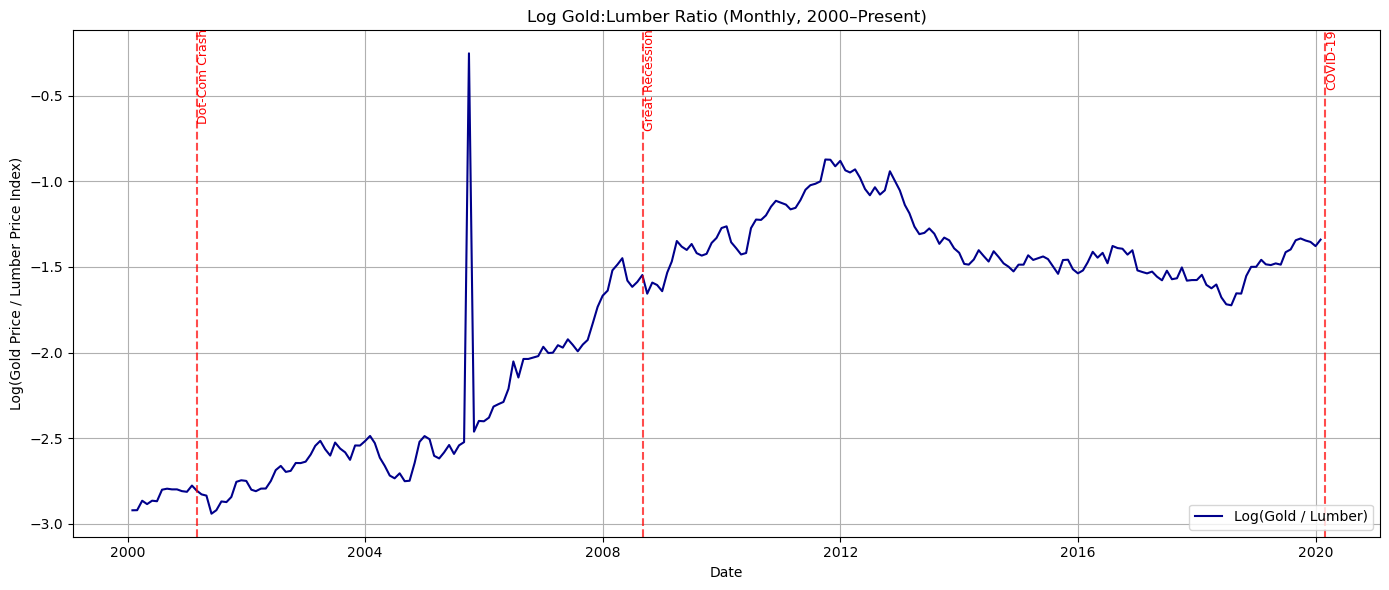

In [10]:
# Importing library
import numpy as np

# Calculating gold and lumber ratio
monthly['Gold_Lumber_Ratio'] = monthly['Gold_Price_USD'] / monthly['Lumber_Price_Index']
monthly['Log_Gold_Lumber_Ratio'] = np.log(monthly['Gold_Lumber_Ratio'])

# Calculating ratio changes
monthly['Log_Ratio_Change'] = monthly['Log_Gold_Lumber_Ratio'].diff()
monthly['Log_Ratio_Pct_Change'] = monthly['Log_Gold_Lumber_Ratio'].pct_change()

# PLotting log ratio with recession notes
plt.figure(figsize=(14, 6))
plt.plot(monthly.index, monthly['Log_Gold_Lumber_Ratio'], color='darkblue', label='Log(Gold / Lumber)')

recessions = {
    'Dot-Com Crash': '2001-03-01',
    'Great Recession': '2008-09-01',
    'COVID-19': '2020-03-01'
}

for label, date in recessions.items():
    plt.axvline(pd.to_datetime(date), color='red', linestyle='--', alpha=0.7)
    plt.text(pd.to_datetime(date), 
             plt.ylim()[1] * 0.95, 
             label, 
             rotation=90, 
             color='red', 
             verticalalignment='top', 
             fontsize=9)

plt.title('Log Gold:Lumber Ratio (Monthly, 2000–Present)')
plt.ylabel('Log(Gold Price / Lumber Price Index)')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Indices Analysis

/var/folders/xh/6p519lr15m14xl0whx7dxdx80000gn/T/ipykernel_1366/1272197967.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_index = df_merged[['SP500_Close', 'NASDAQ_Close', 'DOW_Close']].resample('M').last()


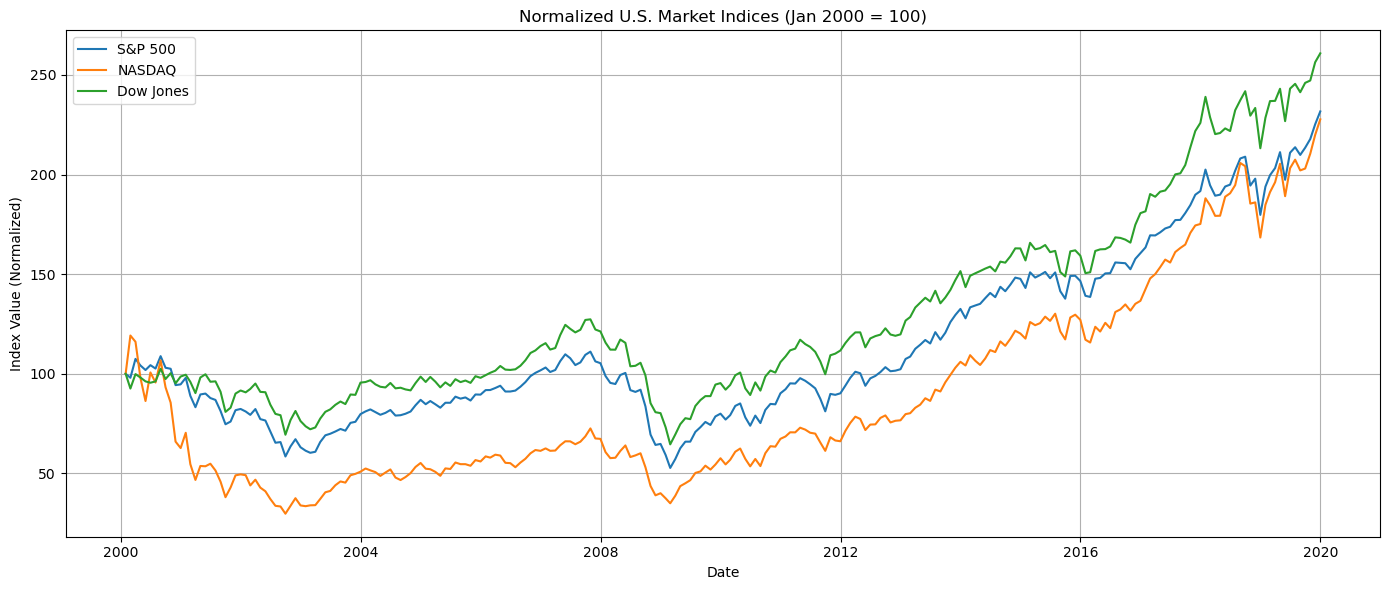

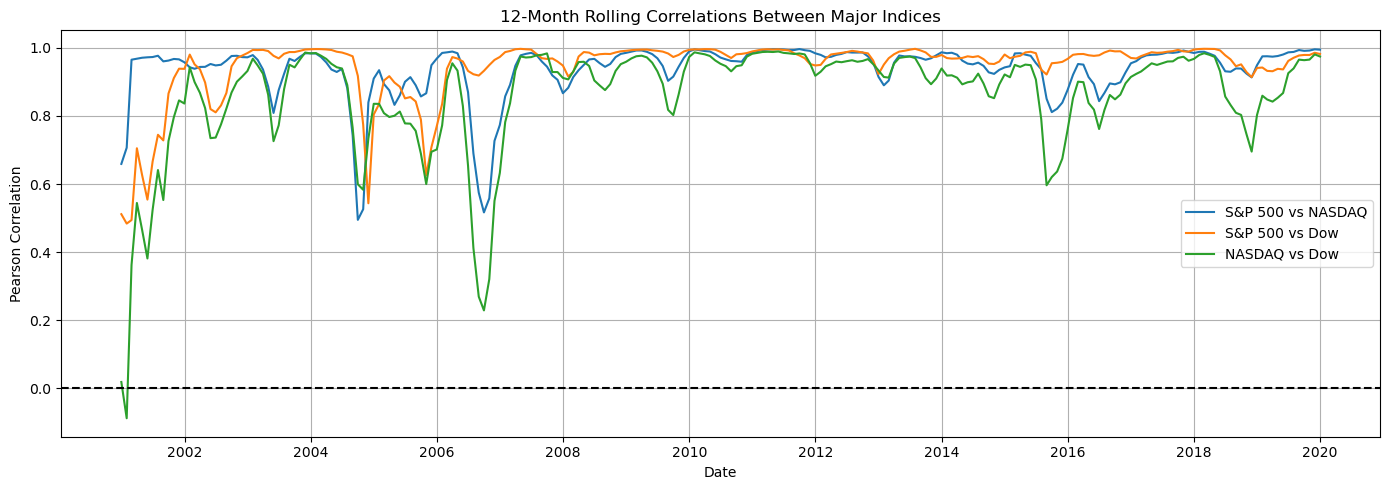

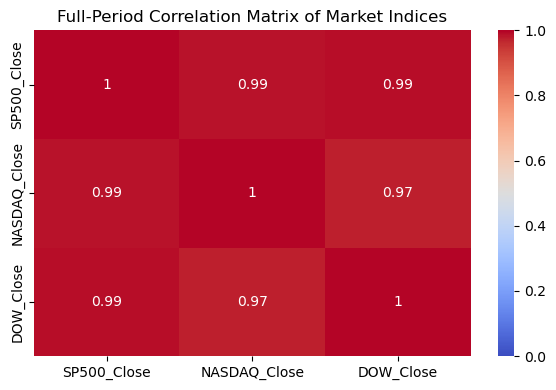

In [12]:
# Resampling to monthly
monthly_index = df_merged[['SP500_Close', 'NASDAQ_Close', 'DOW_Close']].resample('M').last()

# Normalizing scale
indexed = monthly_index / monthly_index.iloc[0] * 100

# Plotting normalized indexes
plt.figure(figsize=(14, 6))
plt.plot(indexed.index, indexed['SP500_Close'], label='S&P 500')
plt.plot(indexed.index, indexed['NASDAQ_Close'], label='NASDAQ')
plt.plot(indexed.index, indexed['DOW_Close'], label='Dow Jones')
plt.title('Normalized U.S. Market Indices (Jan 2000 = 100)')
plt.ylabel('Index Value (Normalized)')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Calculating 12 month correlations
rolling_corr_sp500_nasdaq = monthly_index['SP500_Close'].rolling(12).corr(monthly_index['NASDAQ_Close'])
rolling_corr_sp500_dow = monthly_index['SP500_Close'].rolling(12).corr(monthly_index['DOW_Close'])
rolling_corr_nasdaq_dow = monthly_index['NASDAQ_Close'].rolling(12).corr(monthly_index['DOW_Close'])

# Plotting rolling correlations
plt.figure(figsize=(14, 5))
plt.plot(rolling_corr_sp500_nasdaq.index, rolling_corr_sp500_nasdaq, label='S&P 500 vs NASDAQ')
plt.plot(rolling_corr_sp500_dow.index, rolling_corr_sp500_dow, label='S&P 500 vs Dow')
plt.plot(rolling_corr_nasdaq_dow.index, rolling_corr_nasdaq_dow, label='NASDAQ vs Dow')
plt.title('12-Month Rolling Correlations Between Major Indices')
plt.ylabel('Pearson Correlation')
plt.xlabel('Date')
plt.axhline(0, color='black', linestyle='--')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plotting correlation heat map
corr_matrix = monthly_index.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Full-Period Correlation Matrix of Market Indices')
plt.tight_layout()
plt.show()

/var/folders/xh/6p519lr15m14xl0whx7dxdx80000gn/T/ipykernel_1366/2579337310.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_index_change = daily['Composite_Index'].pct_change()
/var/folders/xh/6p519lr15m14xl0whx7dxdx80000gn/T/ipykernel_1366/2579337310.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_index_change = daily_index_change.resample('M').sum()


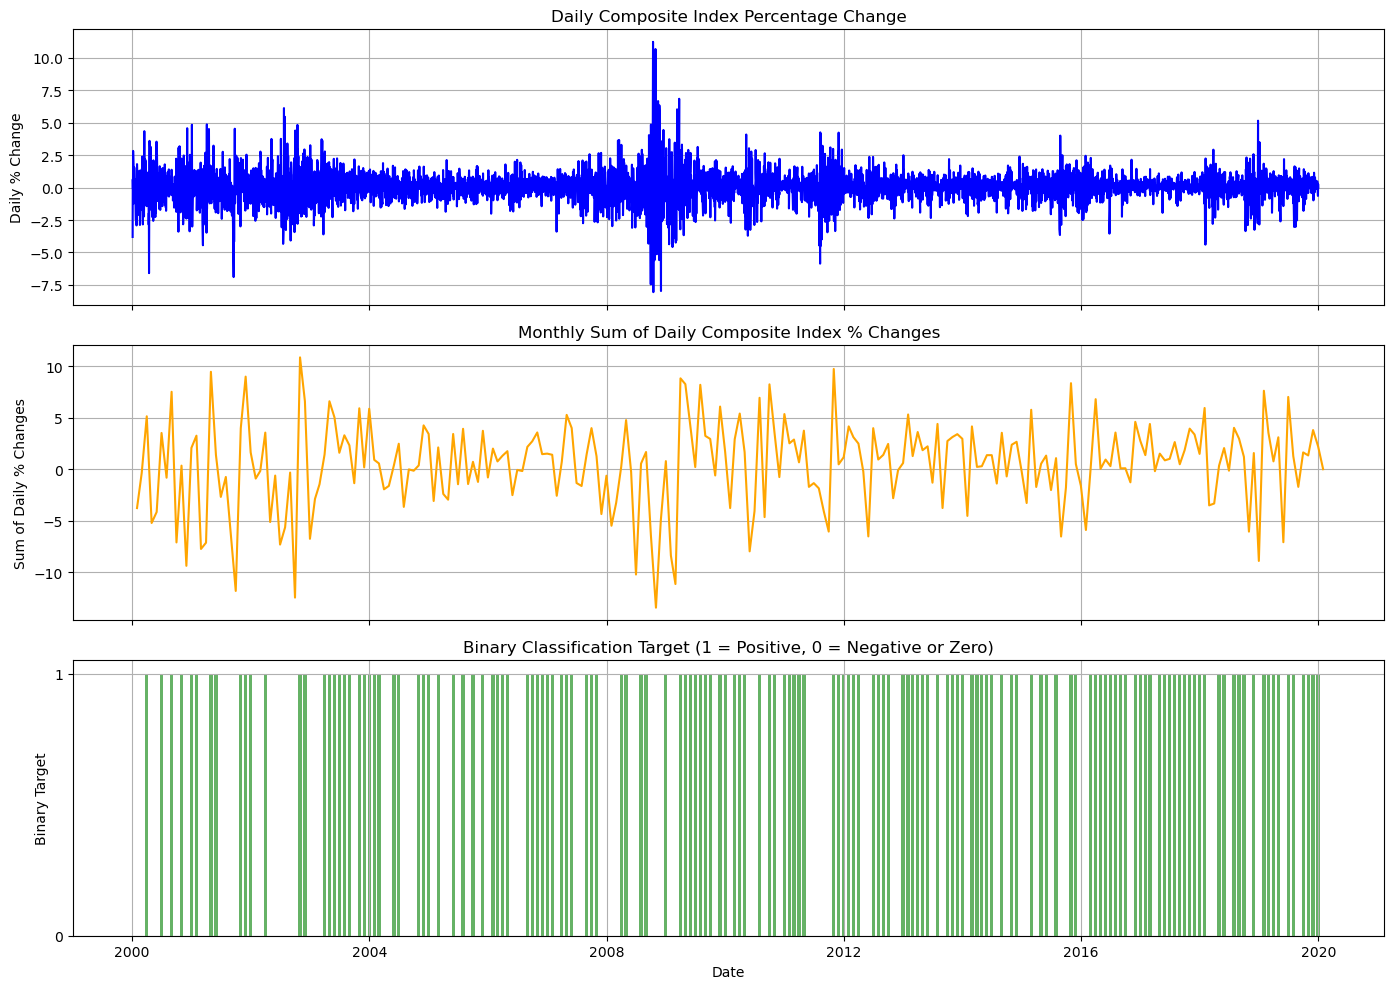

In [13]:
# Creating a daily composite of indexes
daily = df_merged[['SP500_Close', 'NASDAQ_Close', 'DOW_Close']].copy()
daily['Composite_Index'] = daily.mean(axis=1)

# Calculating daily percent change
daily_index_change = daily['Composite_Index'].pct_change()

# Calcualting monthly percent change
monthly_index_change = daily_index_change.resample('M').sum()

# Creating binomial of percent change
binary_target = (monthly_index_change > 0).astype(int)

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Daily percentage changes
axes[0].plot(daily_index_change.index, daily_index_change * 100, color='blue')
axes[0].set_title('Daily Composite Index Percentage Change')
axes[0].set_ylabel('Daily % Change')
axes[0].grid(True)

# Monthly sum of daily changes
axes[1].plot(monthly_index_change.index, monthly_index_change * 100, color='orange')
axes[1].set_title('Monthly Sum of Daily Composite Index % Changes')
axes[1].set_ylabel('Sum of Daily % Changes')
axes[1].grid(True)

# Binary classifier visualization
axes[2].bar(binary_target.index, binary_target, width=20, color='green', alpha=0.6)
axes[2].set_title('Binary Classification Target (1 = Positive, 0 = Negative or Zero)')
axes[2].set_ylabel('Binary Target')
axes[2].set_yticks([0, 1])
axes[2].set_xlabel('Date')
axes[2].grid(True)

plt.tight_layout()
plt.show()

## New Car Sales Analysis

/var/folders/xh/6p519lr15m14xl0whx7dxdx80000gn/T/ipykernel_1366/1970658099.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_merged[['Car_Sales_SAAR', 'SP500_Close', 'NASDAQ_Close', 'DOW_Close']].resample('M').last()


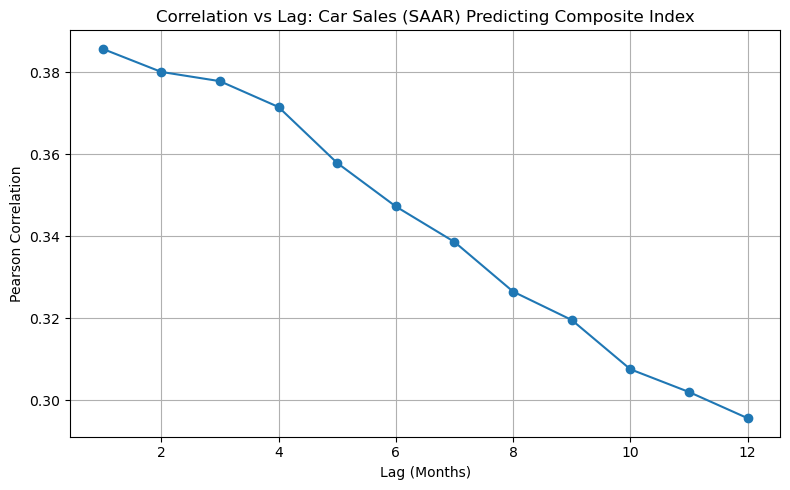

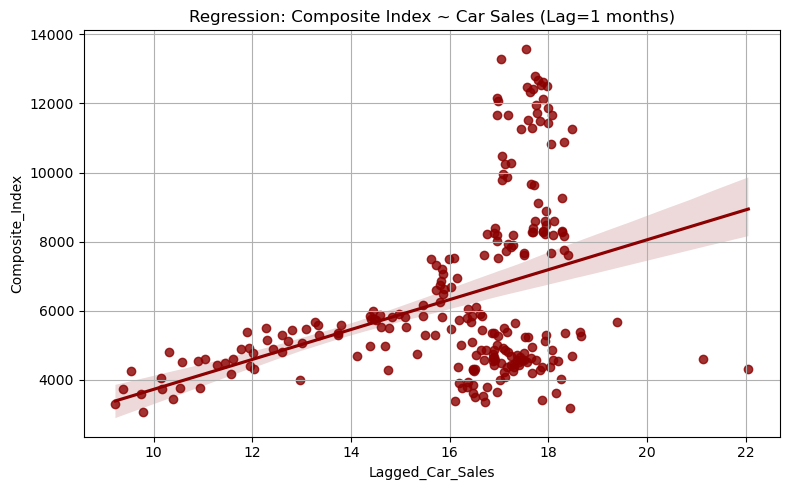

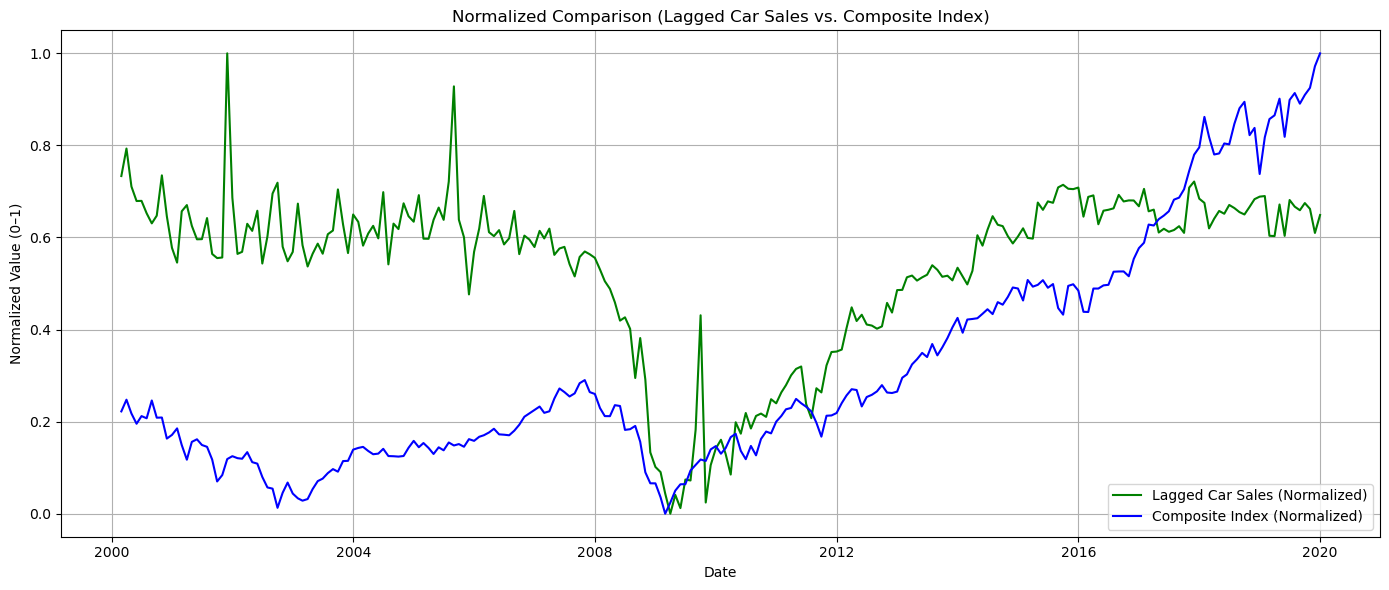

Best Lag: 1
R-squared: 0.14880866974429485
Regression Coefficient: 432.62825015945265
Intercept: -598.1308366069824
P-value: 6.701561271899007e-10


In [15]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

# Resampling and aligning data
monthly = df_merged[['Car_Sales_SAAR', 'SP500_Close', 'NASDAQ_Close', 'DOW_Close']].resample('M').last()
monthly['Composite_Index'] = monthly[['SP500_Close', 'NASDAQ_Close', 'DOW_Close']].mean(axis=1)
monthly = monthly[['Car_Sales_SAAR', 'Composite_Index']].dropna()

# Testing for correlation in lags
correlations = []
for lag in range(1, 13):
    monthly[f'Lagged_Car_Sales_{lag}'] = monthly['Car_Sales_SAAR'].shift(lag)
    temp = monthly.dropna(subset=[f'Lagged_Car_Sales_{lag}', 'Composite_Index'])
    corr = temp['Composite_Index'].corr(temp[f'Lagged_Car_Sales_{lag}'])
    correlations.append({'Lag': lag, 'Correlation': corr})

# Plotting correlation vs lags
corr_df = pd.DataFrame(correlations)
plt.figure(figsize=(8, 5))
plt.plot(corr_df['Lag'], corr_df['Correlation'], marker='o')
plt.title('Correlation vs Lag: Car Sales (SAAR) Predicting Composite Index')
plt.xlabel('Lag (Months)')
plt.ylabel('Pearson Correlation')
plt.grid(True)
plt.tight_layout()
plt.show()

# Choosing best lag and run linear regression
best_lag = corr_df.loc[corr_df['Correlation'].abs().idxmax(), 'Lag']
monthly['Lagged_Car_Sales'] = monthly['Car_Sales_SAAR'].shift(int(best_lag))
reg_data = monthly.dropna(subset=['Lagged_Car_Sales', 'Composite_Index'])

X = sm.add_constant(reg_data['Lagged_Car_Sales'])
y = reg_data['Composite_Index']
model = sm.OLS(y, X).fit()

# Scatter plot with regression line
plt.figure(figsize=(8, 5))
sns.regplot(x='Lagged_Car_Sales', y='Composite_Index', data=reg_data, color='darkred')
plt.title(f'Regression: Composite Index ~ Car Sales (Lag={int(best_lag)} months)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Dual line plot (normalized)
scaler = MinMaxScaler()
norm_data = pd.DataFrame(
    scaler.fit_transform(reg_data[['Lagged_Car_Sales', 'Composite_Index']]),
    columns=['Car_Sales_Norm', 'Composite_Index_Norm'],
    index=reg_data.index
)

plt.figure(figsize=(14, 6))
plt.plot(norm_data.index, norm_data['Car_Sales_Norm'], label='Lagged Car Sales (Normalized)', color='green')
plt.plot(norm_data.index, norm_data['Composite_Index_Norm'], label='Composite Index (Normalized)', color='blue')
plt.title(f'Normalized Comparison (Lagged Car Sales vs. Composite Index)')
plt.ylabel('Normalized Value (0–1)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Printing regression metrics
r_squared = model.rsquared
p_value = model.pvalues['Lagged_Car_Sales']
coef = model.params['Lagged_Car_Sales']
intercept = model.params['const']

print("Best Lag:", int(best_lag))
print("R-squared:", r_squared)
print("Regression Coefficient:", coef)
print("Intercept:", intercept)
print("P-value:", p_value)

## Correlation Analysis

/var/folders/xh/6p519lr15m14xl0whx7dxdx80000gn/T/ipykernel_1366/2121527843.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_merged[['Gold_Price_USD', 'Lumber_Price_Index', 'Car_Sales_SAAR']].resample('M').last().dropna().copy()


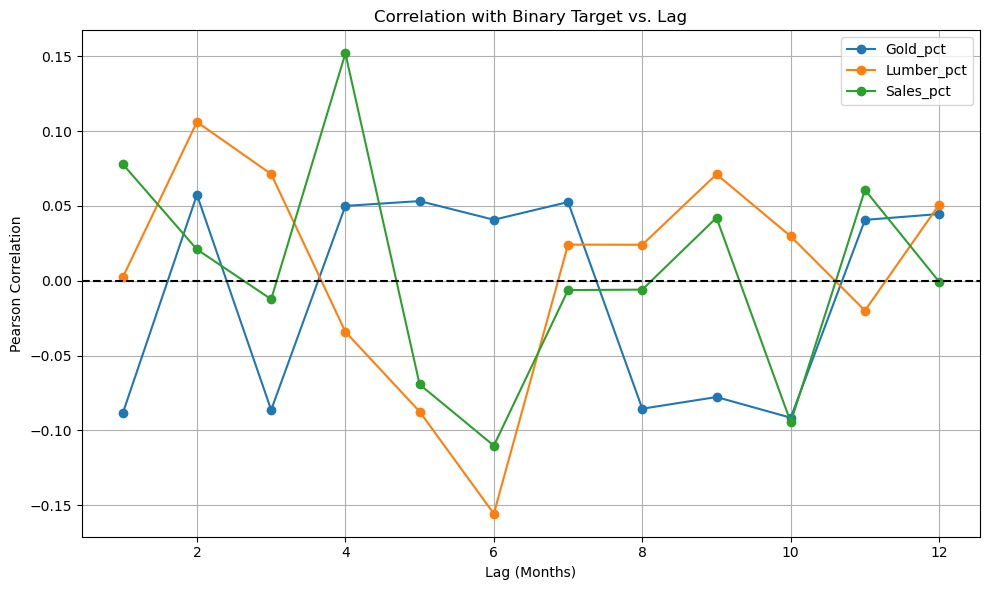

      Variable  Lag  Correlation
9     Gold_pct   10    -0.091471
17  Lumber_pct    6    -0.155569
27   Sales_pct    4     0.151880


In [17]:
# Calculating monthly percentage changes
monthly = df_merged[['Gold_Price_USD', 'Lumber_Price_Index', 'Car_Sales_SAAR']].resample('M').last().dropna().copy()
monthly['Gold_pct'] = monthly['Gold_Price_USD'].pct_change()
monthly['Lumber_pct'] = monthly['Lumber_Price_Index'].pct_change()
monthly['Sales_pct'] = monthly['Car_Sales_SAAR'].pct_change()
monthly.dropna(inplace=True)

# Aligning the binary target
target_aligned = binary_target.reindex(monthly.index).dropna()
monthly = monthly.loc[target_aligned.index]

# Correlation testing
lags = range(1, 13)
results = []

for var in ['Gold_pct', 'Lumber_pct', 'Sales_pct']:
    for lag in lags:
        shifted = monthly[var].shift(lag)
        valid_idx = shifted.dropna().index
        corr = np.corrcoef(shifted.loc[valid_idx], target_aligned.loc[valid_idx])[0, 1]
        results.append({'Variable': var, 'Lag': lag, 'Correlation': corr})

corr_df = pd.DataFrame(results)

# Plotting Correlation vs Lag
fig, ax = plt.subplots(figsize=(10,6))

for var in corr_df['Variable'].unique():
    subset = corr_df[corr_df['Variable'] == var]
    ax.plot(subset['Lag'], subset['Correlation'], marker='o', label=var)

ax.axhline(0, color='black', linestyle='--')
ax.set_title('Correlation with Binary Target vs. Lag')
ax.set_xlabel('Lag (Months)')
ax.set_ylabel('Pearson Correlation')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

# Identify best lags per feature
best_lags = corr_df.loc[corr_df.groupby('Variable')['Correlation'].apply(lambda x: x.abs().idxmax())]
print(best_lags)

### Feature Engineering

In [19]:
# Copying data
monthly_features = monthly[['Gold_Price_USD', 'Lumber_Price_Index', 'Car_Sales_SAAR']].copy()


for col in monthly_features.columns:
    # Rolling means
    monthly_features[f'{col}_MA3']  = monthly_features[col].rolling(window=3).mean()
    monthly_features[f'{col}_MA6']  = monthly_features[col].rolling(window=6).mean()
    # Rolling volatility
    monthly_features[f'{col}_Vol3'] = monthly_features[col].rolling(window=3).std()
    monthly_features[f'{col}_Vol6'] = monthly_features[col].rolling(window=6).std()
    # 3-month momentum
    monthly_features[f'{col}_Mom3'] = monthly_features[col].pct_change(periods=3)

# Interaction term
monthly_features['Gold_to_Lumber'] = (
    monthly_features['Gold_Price_USD'] / monthly_features['Lumber_Price_Index']
)

# Drop raw price/sales columns
monthly_features.drop(
    columns=['Gold_Price_USD', 'Lumber_Price_Index', 'Car_Sales_SAAR'],
    inplace=True
)

# Align with target and drop NaNs from rolling calculations
X = monthly_features.loc[target_aligned.index].dropna()
y = target_aligned.loc[X.index]

### ML Models

#### XGBoost

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Params: {'subsample': 1.0, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}

Accuracy: 0.7021276595744681
ROC AUC: 0.8802952999381571

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.23      0.36        88
           1       0.68      0.99      0.81       147

    accuracy                           0.70       235
   macro avg       0.79      0.61      0.58       235
weighted avg       0.77      0.70      0.64       235

Confusion Matrix:
 [[ 20  68]
 [  2 145]]


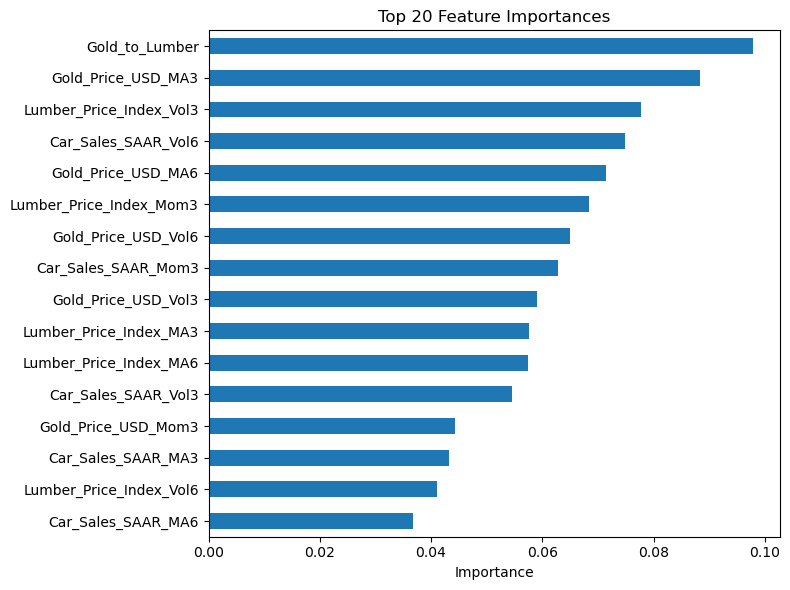

In [22]:
# Importing libraries
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)

# Defining time series
tscv = TimeSeriesSplit(n_splits=5)

# Initializeing XGBC
xgb_clf = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Hyperparameter grid
param_dist = {
    'n_estimators':    [50, 100, 200, 300],
    'max_depth':       [2, 3, 4, 5, 6],
    'learning_rate':   [0.01, 0.05, 0.1, 0.2],
    'subsample':       [0.6, 0.8, 1.0],
    'colsample_bytree':[0.6, 0.8, 1.0],
}

# RandomizedSearchCV
rand_search = RandomizedSearchCV(
    estimator   = xgb_clf,
    param_distributions = param_dist,
    n_iter      = 50,
    cv          = tscv,
    scoring     = 'roc_auc',
    verbose     = 2,
    n_jobs      = -1,
    random_state= 42
)

rand_search.fit(X, y)
print("Best Params:", rand_search.best_params_)

# Retrieve best model and predictions
best_model = rand_search.best_estimator_
y_pred      = best_model.predict(X)
y_proba     = best_model.predict_proba(X)[:, 1]

# Evaluation
print("\nAccuracy:", accuracy_score(y, y_pred))
print("ROC AUC:", roc_auc_score(y, y_proba))
print("\nClassification Report:\n", classification_report(y, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))

# Feature Importances
imp = pd.Series(best_model.feature_importances_, index=X.columns)
top_imp = imp.sort_values(ascending=False).head(20)

plt.figure(figsize=(8,6))
top_imp.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

#### F1 Score

In [24]:
# Importing libraries
from sklearn.metrics import f1_score

# Split off the last 6 months as a hold-out test set
test_size = 6
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

# Retrain best_model on the training portion only
best_model.fit(X_train, y_train)

# Get predicted probabilities on the test set
y_proba_test = best_model.predict_proba(X_test)[:, 1]

# Evaluate at default 0.5 threshold
y_pred_default = (y_proba_test > 0.5).astype(int)
print("Default threshold (0.5):")
print(" Accuracy =", accuracy_score(y_test, y_pred_default))
print(" ROC AUC =", roc_auc_score(y_test, y_proba_test))
print(classification_report(y_test, y_pred_default))

# Threshold tuning: scan F1-score over a range of thresholds
thresholds = np.linspace(0.1, 0.9, 41)
f1_scores = [f1_score(y_test, (y_proba_test > t).astype(int)) for t in thresholds]
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
print(f"\nBest F1 = {f1_scores[best_idx]:.3f} at threshold = {best_thresh:.2f}")

# Evaluate at the optimal threshold
y_pred_opt = (y_proba_test > best_thresh).astype(int)
print(f"\nEvaluation at threshold {best_thresh:.2f}:")
print(" Accuracy =", accuracy_score(y_test, y_pred_opt))
print(" ROC AUC =", roc_auc_score(y_test, y_proba_test))
print(classification_report(y_test, y_pred_opt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_opt))

Default threshold (0.5):
 Accuracy = 0.6666666666666666
 ROC AUC = 0.5625
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.67      1.00      0.80         4

    accuracy                           0.67         6
   macro avg       0.33      0.50      0.40         6
weighted avg       0.44      0.67      0.53         6


Best F1 = 0.800 at threshold = 0.10

Evaluation at threshold 0.10:
 Accuracy = 0.6666666666666666
 ROC AUC = 0.5625
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.67      1.00      0.80         4

    accuracy                           0.67         6
   macro avg       0.33      0.50      0.40         6
weighted avg       0.44      0.67      0.53         6

Confusion Matrix:
 [[0 2]
 [0 4]]


#### Sliding-Window Backtest

In [26]:
window_size = 120 
preds, trues = [], []

for start in range(0, len(X) - window_size - 1):
    train_idx = range(start, start + window_size)
    test_idx  = start + window_size

    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test,  y_test  = X.iloc[[test_idx]], y.iloc[[test_idx]]
    
    model = xgb.XGBClassifier(
        use_label_encoder=False, verbosity=0, eval_metric='logloss', random_state=42,
        **rand_search.best_params_
    )
    model.fit(X_train, y_train)
    pred = model.predict(X_test)[0]
    
    preds.append(pred)
    trues.append(y_test.iloc[0])

accuracy = accuracy_score(trues, preds)
print(f"Sliding-window accuracy: {accuracy:.3f}")

Sliding-window accuracy: 0.702
